# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [47]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-01-16/data_eval_new/"
file_name = "int_norm_20170116_bgd_old.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [48]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [10]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [49]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

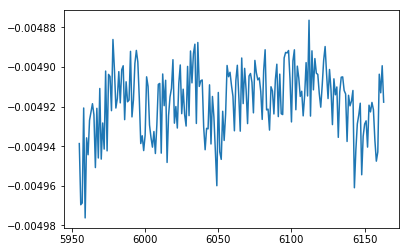

In [50]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

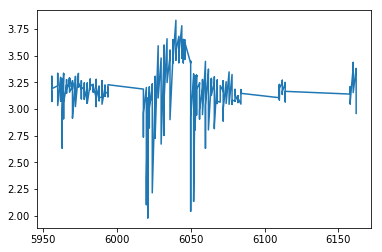

In [51]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

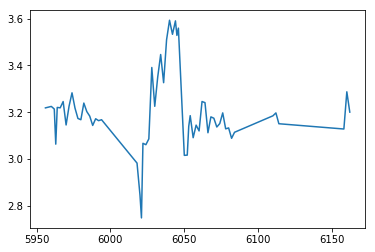

In [52]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

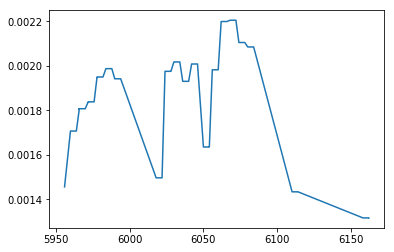

In [53]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [54]:
background_mean = df_mean(background)

# Outlier rejection

In [84]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [85]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [86]:
column = "124/118"
sample = "NIST 200ppb"

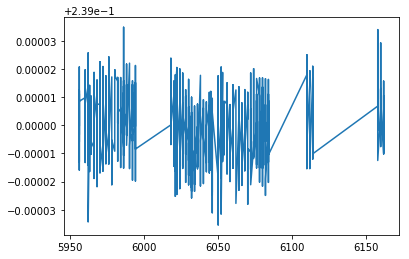

In [87]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [88]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [89]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2017-01-16 20:19:00,NIST 200ppb,2,1,5956,0.040158,0.027189,NaN,0.600333,0.316795,0.354707,1.345956,0.19125,0.239005
2017-01-16 20:19:00,NIST 200ppb,2,2,5956,0.040153,0.027181,NaN,0.600339,0.316785,0.354686,1.345934,0.19125,0.239000
2017-01-16 20:19:00,NIST 200ppb,2,3,5956,0.040158,0.027183,0.013945,0.600329,0.316786,0.354692,1.345976,0.19125,0.239021
2017-01-16 20:19:00,NIST 200ppb,2,4,5956,0.040146,0.027177,0.013948,0.600354,0.316790,0.354699,1.345942,0.19125,0.239018
2017-01-16 20:19:00,NIST 200ppb,2,5,5956,0.040151,0.027180,0.013947,0.600343,0.316792,0.354684,1.345903,0.19125,0.239010
2017-01-16 20:19:00,NIST 200ppb,2,6,5956,0.040158,0.027182,0.013947,0.600354,0.316787,0.354688,1.345922,0.19125,0.238997
2017-01-16 20:19:00,NIST 200ppb,2,7,5956,0.040155,0.027181,0.013948,0.600359,0.316790,0.354678,1.345926,0.19125,0.239011
2017-01-16 20:19:00,NIST 200ppb,2,8,5956,0.040151,0.027178,0.013945,0.600350,0.316799,0.354680,1.345932,NaN,0.238997
2017-01-16 20:19:00,NIST 200ppb,2,9,5956,0.040151,0.027179,0.013947,0.600349,0.316793,0.354705,1.345944,NaN,0.239010


In [90]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
5960        2017-01-16 21:11:00    0.258851
5961        2017-01-16 21:25:00    0.258770
            2017-01-16 21:25:00    0.258745
            2017-01-16 21:25:00    0.258745
5962        2017-01-16 21:40:00    0.258844
            2017-01-16 21:40:00    0.258826
            2017-01-16 21:40:00    0.258803
5964        2017-01-16 22:10:00    0.258720
5978        2017-01-17 01:23:00    0.258865
5982        2017-01-17 02:22:00    0.258943
5984        2017-01-17 02:47:00    0.258900
5985        2017-01-17 03:02:00    0.258838
5988        2017-01-17 03:46:00    0.258901
            2017-01-17 03:46:00    0.258911
5991        2017-01-17 04:26:00    0.258816
6004        2017-01-17 07:29:00    0.259255
6006        2017-01-17 07:58:00    0.259287
6019        2017-01-17 11:44:00    0.258772
            2017-01-17 11:44:00    0.258716
            2017-01-17 11:44:00    0.258785
            2017-01-17 11:44:00    0.258756
6020        2017-01-17 11:58:00    0.258638


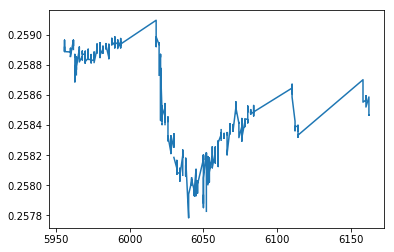

In [91]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [92]:
df[df["Sample"] == sample][column].std()

0.00033642506292654245

In [93]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

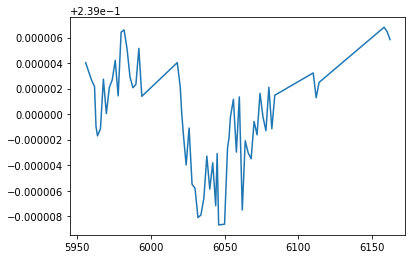

In [94]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [95]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2017-01-16 20:19:00,5956,NIST 200ppb,0.040153,0.027181,0.013947,0.600351,0.316792,0.354690,1.345940,0.19125,0.239004
2017-01-16 20:45:00,5958,NIST 350ppb,0.040151,0.027179,0.013948,0.600360,0.316794,0.354690,1.345913,0.19125,0.239001
2017-01-16 21:11:00,5960,NIST 200ppb,0.040151,0.027177,0.013948,0.600347,0.316788,0.354688,1.345943,0.19125,0.239003
2017-01-16 21:25:00,5961,NIST 350ppb,0.040151,0.027178,0.013948,0.600353,0.316787,0.354685,1.345926,0.19125,0.239003
2017-01-16 21:40:00,5962,NIST 200ppb,0.040152,0.027179,0.013947,0.600356,0.316787,0.354682,1.345951,0.19125,0.239002
2017-01-16 21:55:00,5963,NIST 200ppb,0.040152,0.027179,0.013947,0.600351,0.316784,0.354681,1.345947,0.19125,0.238999
2017-01-16 22:10:00,5964,NIST 200ppb,0.040150,0.027178,0.013947,0.600351,0.316785,0.354680,1.345950,0.19125,0.238998
2017-01-16 22:35:00,5966,NIST 200ppb,0.040154,0.027181,0.013948,0.600355,0.316783,0.354679,1.345948,0.19125,0.238999
2017-01-16 22:50:00,5967,NIST 200ppb + 1ppb Mo,0.040153,0.027179,0.013947,0.600359,0.316783,0.354680,1.345951,0.19125,0.239000


In [96]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [97]:
drop_sum = [pd.Timestamp("2017-01-18 09:39"), 
            pd.Timestamp("2017-01-18 10:08"),
            pd.Timestamp("2017-01-18 10:51"), 
            pd.Timestamp("2017-01-18 21:05"), 
            pd.Timestamp("2017-01-18 21:35"), 
            pd.Timestamp("2017-01-18 22:04")]

In [98]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [99]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [100]:
data_mean_int_sum

112/118                       114/118  \
                               mean           SD2 count      mean   
Sample                                                              
Allende HP 1_2             0.040142           NaN     1  0.027178   
EET92048 bomb 1_1          0.040141           NaN     1  0.027181   
GRA06100 bomb 1_1          0.040136           NaN     1  0.027172   
J.W. bomb 1_2              0.040141           NaN     1  0.027178   
MIL09001 bomb 1_1          0.040141           NaN     1  0.027175   
Murchison bomb 1_2         0.040141           NaN     1  0.027178   
NIST 200ppb                0.040147  7.157959e-06    56  0.027178   
NIST 200ppb + 0.005ppb U   0.040148  5.334374e-06     2  0.027179   
NIST 200ppb + 0.030ppb Cd  0.040149  7.085619e-06     2  0.027183   
NIST 200ppb + 0.04ppb Cd   0.040148  9.620773e-07     2  0.027181   
NIST 200ppb + 0.100ppb Zr  0.040148  7.429441e-06     2  0.027177   
NIST 200ppb + 0.150ppb Rh  0.040149  5.423674e-06     2  0.027178   
NIST 200ppb + 0.300ppb Ru  0.040147  7.142285e-06     2  0.027177   
NIST 200ppb + 0.50ppb Pd   0.040149  1.437980e-05     2  0.027177   
NIST 200ppb + 0.628ppb Te  0.040149  9.753541e-06     2  0.027180   
NIST 200ppb + 1ppb Mo      0.040147  1.692408e-05     2  0.027176   
NIST 200ppb + 2pbb Mo      0.040145           NaN     1  0.027175   
NIST 200ppb + 2ppb Mo      0.040144           NaN     1  0.027177   
NIST 200ppb + ME           0.040149  5.258086e-07     2  0.027179   
NIST 25ppb                 0.040139  2.128082e-05    27  0.027172   
NIST 25ppb + 0.013ppb U    0.040125  1.557867e-05     2  0.027153   
NIST 25ppb + 0.021ppb Cd   0.040139           NaN     1  0.027182   
NIST 25ppb + 0.060ppb Rh   0.040135           NaN     1  0.027152   
NIST 25ppb + 0.075ppb Te   0.040137           NaN     1  0.027168   
NIST 25ppb + 0.12ppb Ru    0.040138           NaN     1  0.027165   
NIST 25ppb + 1.88ppb Mo    0.040144  1.992062e-05     2  0.027176   
NIST 25ppb + 8.0ppb Zn     0.040133           NaN     1  0.027151   
NIST 350ppb                0.040148  7.752952e-06     4  0.027178   
NIST 6ppb                  0.040146  7.812152e-05    28  0.027197   
NIST 6ppb + 0.013ppb U     0.040151           NaN     1  0.027203   
NIST 6ppb + 0.02ppb Cd     0.040147           NaN     1  0.027260   
NIST 6ppb + 0.06ppb Rh     0.040107           NaN     1  0.027066   
NIST 6ppb + 0.06ppb Ru     0.040160  6.231771e-05     2  0.027247   
NIST 6ppb + 0.08ppb Te     0.040174  1.504004e-04     2  0.027186   
NIST 6ppb + 0.86ppb Mo     0.040089  3.582775e-05     2  0.027165   
NIST 6ppb + 38ppb Zn       0.040139  1.935101e-04     2  0.027168   
ZH09-05 23.3_3b_3          0.040145           NaN     1  0.027178   

                                                115/118                      \
                                    SD2 count      mean           SD2 count   
Sample                                                                        
Allende HP 1_2                      NaN     1  0.013944           NaN     1   
EET92048 bomb 1_1                   NaN     1  0.013944           NaN     1   
GRA06100 bomb 1_1                   NaN     1  0.013944           NaN     1   
J.W. bomb 1_2                       NaN     1  0.013944           NaN     1   
MIL09001 bomb 1_1                   NaN     1  0.013944           NaN     1   
Murchison bomb 1_2                  NaN     1  0.013944           NaN     1   
NIST 200ppb                3.825890e-06    56  0.013947  1.304858e-06    56   
NIST 200ppb + 0.005ppb U   1.384590e-07     2  0.013947  3.527239e-06     2   
NIST 200ppb + 0.030ppb Cd  3.146088e-06     2  0.013946  5.936978e-07     2   
NIST 200ppb + 0.04ppb Cd   5.201304e-06     2  0.013947  1.925022e-07     2   
NIST 200ppb + 0.100ppb Zr  3.432952e-06     2  0.013947  4.791992e-07     2   
NIST 200ppb + 0.150ppb Rh  2.908996e-06     2  0.013948  2.320162e-06     2   
NIST 200ppb + 0.300ppb Ru  4.666641e-09     2  0.013947  1.810821e-06     2   
NIS

In [101]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_6 = SSB(data_mean_int.drop(date_list), "NIST 6ppb", 10000)
delta_raw_6 = SSB(data_mean_raw.drop(date_list), "NIST 6ppb", 1000)
epsilon_int_25 = SSB(data_mean_int.drop(date_list), "NIST 25ppb", 10000)
delta_raw_25 = SSB(data_mean_raw.drop(date_list), "NIST 25ppb", 1000)

In [102]:
epsilon_int_6

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2017-01-17 05:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 6ppb
2017-01-17 05:50:00,0.000000,-15.549324,7.761573,6.150605,0.426989,0.124040,0.188294,0.385958,2.220446e-12,1.116693,NIST 6ppb
2017-01-17 06:05:00,0.000000,12.478536,-16.795698,25.372553,-1.129865,-0.020863,-0.024092,-0.729390,-1.110223e-12,-2.128832,NIST 6ppb
2017-01-17 06:19:00,0.000000,3.445330,22.685788,-30.577043,1.351244,0.184403,0.743521,0.745956,0.000000e+00,2.501429,NIST 6ppb
2017-01-17 06:34:00,-0.833264,-14.922959,-24.256846,-6.195234,-0.490216,-0.397533,-0.923503,-1.565686,0.000000e+00,-2.399169,NIST 6ppb
2017-01-17 07:00:00,0.000000,11.754049,20.117353,14.179090,-1.014884,-0.938843,-0.413549,1.809354,-1.110223e-12,2.002856,NIST 6ppb
2017-01-17 07:14:00,0.000000,-14.907849,-33.862958,1.317377,-0.390629,-0.813604,-0.440134,0.280284,0.000000e+00,-1.099523,NIST 6ppb + 0.86ppb Mo
2017-01-17 07:29:00,0.000000,-6.433492,-6.020639,1.459733,0.697563,2.211114,1.368142,-1.203252,2.220446e-12,-1.038541,NIST 6ppb
2017-01-17 07:44:00,0.000000,-5.080809,18.439362,-4.718089,-0.412040,-0.818857,-0.213287,0.087617,-1.110223e-12,0.157767,NIST 6ppb + 0.06ppb Ru


In [103]:

date_list_6 = [pd.Timestamp("2017-01-17 19:52:00")]

epsilon_int_200 = epsilon_int_200
delta_raw_200 = delta_raw_200
epsilon_int_6 = epsilon_int_6.drop(date_list_6)
delta_raw_6 = delta_raw_6.drop(date_list_6)
epsilon_int_25 = epsilon_int_25.drop(date_list)
delta_raw_25 = delta_raw_25.drop(date_list)

In [104]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [105]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)
epsilon_int_6 = epsilon_process(epsilon_int_6)
delta_raw_6 = epsilon_process(delta_raw_6)
epsilon_int_25 = epsilon_process(epsilon_int_25)
delta_raw_25 = epsilon_process(delta_raw_25)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [106]:
epsilon_int_25

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2017-01-18 11:31:00,6117,-2.745362,-0.705164,-3.045656,-0.518199,-0.050113,0.075007,0.200230,0.000000e+00,0.820763,NIST 25ppb
2017-01-18 11:46:00,6118,-0.535265,0.795830,5.392296,0.166656,-0.390487,-0.093452,-0.337136,0.000000e+00,-0.623646,NIST 25ppb
2017-01-18 12:00:00,6119,0.194488,-1.290809,-4.658796,-0.175292,0.257568,0.367043,-0.018370,0.000000e+00,0.347297,NIST 25ppb
2017-01-18 12:15:00,6120,-0.433040,-1.150009,1.478477,0.195879,0.240348,-0.385110,0.359892,2.220446e-12,0.435924,NIST 25ppb
2017-01-18 12:40:00,6122,2.632432,0.462910,2.565045,0.180020,-0.015384,0.040733,-0.506807,0.000000e+00,-1.098985,NIST 25ppb
2017-01-18 12:55:00,6123,-3.584261,-8.656950,3.115973,0.043336,0.352163,-0.217509,0.149461,0.000000e+00,0.470736,NIST 25ppb + 1.88ppb Mo
2017-01-18 13:10:00,6124,0.229554,7.558235,-2.158809,-0.209693,-0.442177,0.105748,0.235350,2.220446e-12,0.932644,NIST 25ppb
2017-01-18 13:24:00,6125,-0.331867,-4.674712,-2.872586,0.344526,0.358301,-0.166011,-0.330450,0.000000e+00,-0.292085,NIST 25ppb + 0.12ppb Ru
2017-01-18 13:39:00,6126,-0.856457,-6.519806,-1.456340,-0.040319,0.177615,0.169056,0.116273,0.000000e+00,-0.502908,NIST 25ppb


In [107]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_6_sum = np.round(epsilon_int_6.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_6_sum = np.round(delta_raw_6.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_25_sum = np.round(epsilon_int_25.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_25_sum = np.round(delta_raw_25.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum.append([epsilon_int_6_sum, epsilon_int_25_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum.append([delta_raw_6_sum, delta_raw_25_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [108]:
epsilon_sum_all

112/118               114/118               115/118  \
                             mean     SD2 count    mean     SD2 count    mean   
Sample                                                                          
Allende HP 1_2             -0.440     NaN     1   1.141     NaN     1  -2.313   
EET92048 bomb 1_1          -0.330     NaN     1   1.395     NaN     1  -2.232   
GRA06100 bomb 1_1          -1.648     NaN     1  -1.886     NaN     1  -1.837   
J.W. bomb 1_2              -1.161     NaN     1  -0.045     NaN     1  -1.895   
MIL09001 bomb 1_1          -0.360     NaN     1  -0.494     NaN     1  -1.797   
Murchison bomb 1_2         -1.228     NaN     1  -0.089     NaN     1  -1.928   
NIST 200ppb                 0.016   0.881    51   0.007   1.096    51  -0.009   
NIST 200ppb + 0.005ppb U   -0.080   0.319     2  -0.134   0.994     2   0.223   
NIST 200ppb + 0.030ppb Cd   0.282   0.247     2   1.469   0.626     2  -0.503   
NIST 200ppb + 0.04ppb Cd    0.055   1.575     2   0.384   2.426     2   0.177   
NIST 200ppb + 0.100ppb Zr   0.116   1.034     2  -0.067   2.482     2   0.012   
NIST 200ppb + 0.150ppb Rh   0.064   0.746     2   0.073   0.105     2   0.475   
NIST 200ppb + 0.300ppb Ru  -0.090   0.621     2  -0.060   0.284     2  -0.212   
NIST 200ppb + 0.50ppb Pd    0.067   0.668     2  -0.407   0.923     2   0.126   
NIST 200ppb + 0.628ppb Te   0.191   1.016     2  -0.057   1.720     2  -0.467   
NIST 200ppb + 1ppb Mo      -0.503   1.294     2  -1.040   0.576     2  -0.176   
NIST 200ppb + 2pbb Mo       0.074     NaN     1  -0.907     NaN     1   1.138   
NIST 200ppb + 2ppb Mo      -0.001     NaN     1   0.386     NaN     1  -0.074   
NIST 200ppb + ME            0.070   0.415     2   0.337   0.564     2   0.216   
NIST 25ppb                  4.545     NaN     1  -0.154     NaN     1   2.063   
NIST 350ppb                -0.197   0.318     4   0.230   0.752     4   0.461   
NIST 6ppb                   0.485     NaN     1   7.614     NaN     1   0.838   
ZH09-05 23.3_3b_3           0.273     NaN     1   1.312     NaN     1  -0.626   
NIST 6ppb                  -0.408  23.883    23   0.294  43.864    23   1.063   
NIST 6ppb + 0.013ppb U      0.320     NaN     1  20.022     NaN     1   2.874   
NIST 6ppb + 0.02ppb Cd     10.077     NaN     1  58.355     NaN     1 -15.872   
NIST 6ppb + 0.06ppb Rh     -3.475     NaN     1 -34.021     NaN     1  20.557   
NIST 6ppb + 0.06ppb Ru      7.274  34.943     2  24.735  17.808     2 -23.210   
NIST 6ppb + 0.08ppb Te      4.556  41.698     2 -11.612   3.192     2   9.421   
NIST 6ppb + 0.86ppb Mo    -14.709   0.563     2 -15.237  52.682     2 -16.979   
NIST 6ppb + 38ppb Zn       -6.281  27.328     2 -18.035  26.294     2  14.926   
NIST 200ppb                -2.729     NaN     1  -2.762     NaN     1   0.167   
NIST 25ppb                 -0.077   5.319    24   0.001  10.729    24   0.077   
NIST 25ppb + 0.013ppb U    -1.740   5.109     2  -3.055   2.086     2  -3.427   
NIST 25ppb + 0.021ppb Cd   -0.175     NaN     1   6.508     NaN     1  -0.851   
NIST 25ppb + 0.060ppb Rh   -1.619     NaN     1  -7.124     NaN     1   7.478   
NIST 25ppb + 0.075ppb Te    0.093     NaN     1  -2.360     NaN     1  -4.702   
NIST 25ppb + 0.12ppb Ru    -0.332     NaN     1  -4.675     NaN     1  -2.873   
NIST 25ppb + 1.88ppb Mo    -0.457   8.845     2  -1.297  20.818     2   2.111   
NIST 25ppb + 8.0ppb Zn      0.575     NaN     1  -7.494     NaN     1   4.814   

                                        116/118  ...  119/118 120/118         \
                              SD2 count    mean  ...    count    mean    SD2   
Sample                                           ...                           
Allende HP 1_2                NaN     1  -0.158  ...        1   0.014    NaN   
EET92048 bomb 1_1             NaN     1   0.005  ...        1  -0.017    NaN   
GRA06100 bomb 1_1             NaN     1  -0.263  ...        1   0.043    NaN   
J.W. bomb 1_2                 NaN     1  -0.164  ...        1 

In [109]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200.append([epsilon_int_6, epsilon_int_25], min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200.append([delta_raw_6, delta_raw_25], min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

SyntaxError: invalid syntax (<ipython-input-109-46d5f69f4564>, line 6)

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [166]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [167]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [110]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_old.xlsx', engine='xlsxwriter')


In [111]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.append([epsilon_int_6, epsilon_int_25]).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.append([delta_raw_6, delta_raw_25]).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [112]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [113]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')